# TP RNN 
# Using Many-to-One for movie rating predicton

For any remark or suggestion, please feel free to contact me at:
geoffroy.peeters@telecom-paristech.fr

Last edit: 2019/01/15 geoffroy.peeters@telecom-paristech.fr

### Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

### Import packages

In [0]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras import Model
from keras import backend as K

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zerp-pad each sequence a length ```max_review_length````

In [0]:
top_words = 5000 
max_review_length = 100
INDEX_FROM = 3

## Import IMDB data

In [0]:
# Import the IMDB data and only consider the ``top_words``` most used words
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)

# restore np.load for future normal usage
np.load = np_load_old

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[0]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

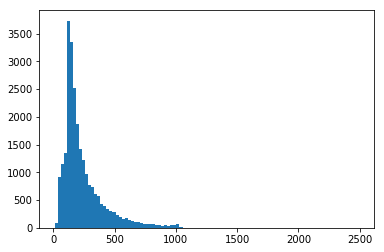

In [0]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[0]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [0]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

1646592/1641221 [==============================] - 1s 1us/step
<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a brig

In [0]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [0]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [0]:
# truncate and pad input sequences

# CODE-RNN1-1
# --- START CODE HERE

from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_review_length, truncating='post')

# --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
    2   16]


## First model

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each of item of a sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, it is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a seuqnece over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid ()predicting the 0 or 1 rating)



In [0]:
K.clear_session()

In [0]:
top_words

5000

In [0]:
# create the model
embedding_vector_length = 32

# CODE-RNN1-2
# --- START CODE HERE
model = Sequential()
model.add(Embedding(input_dim=top_words,output_dim=embedding_vector_length,input_length=max_review_length))

model.add(Lambda(lambda x: K.mean(x,axis=2))) #On moyenne sur l'axe 1
model.add(Dense(1,activation='sigmoid'))
# --- END CODE HERE


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 32)           160000    
_________________________________________________________________
lambda_8 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 160,101
Trainable params: 160,101
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(pad_sequences(X_test, maxlen=max_review_length, truncating='post'), y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 3s 110us/step - loss: 0.5040 - acc: 0.7856 - val_loss: 0.4778 - val_acc: 0.7898
Epoch 2/3
25000/25000 [==============================] - 2s 99us/step - loss: 0.4236 - acc: 0.8224 - val_loss: 0.4316 - val_acc: 0.8062
Epoch 3/3
25000/25000 [==============================] - 2s 100us/step - loss: 0.3793 - acc: 0.8408 - val_loss: 0.4091 - val_acc: 0.8147


## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [0]:
# Final evaluation of the model
scores = model.evaluate(pad_sequences(X_test, maxlen=max_review_length, truncating='post'), y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 81.47%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```amazing```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```amazing``` in the dictionary
- Get the word-embedding of ```amazing```
- Find (using Euclidean distance), the closest embedded-words to ```amazing```

In [0]:
print("The place of 'amazing' in the dictionary is : "+ str(word_to_id['amazing']))

The place of 'amazing' in the dictionary is : 480


In [0]:
print("The weights of the model are : ")
print(model.get_weights())

The weights of the model are : 
[array([[-0.00790717,  0.03841444,  0.00455475, ...,  0.04148004,
        -0.03415649, -0.0281969 ],
       [-0.01801296,  0.04038786,  0.0092701 , ...,  0.07582682,
         0.06988745, -0.01431165],
       [-0.0253833 ,  0.00787978, -0.01005355, ..., -0.04851655,
        -0.0417084 ,  0.00697946],
       ...,
       [-0.07406791, -0.06049516, -0.14291629, ..., -0.06816488,
        -0.0687961 , -0.1497755 ],
       [-0.14843555, -0.08725898, -0.12333208, ..., -0.16109037,
        -0.10328294, -0.09267753],
       [-0.04714959, -0.10915976, -0.08194903, ..., -0.06773883,
        -0.04481061, -0.06777909]], dtype=float32), array([[-0.18477465],
       [ 0.8254218 ],
       [ 0.9405272 ],
       [ 0.84182715],
       [ 0.864078  ],
       [ 0.69249797],
       [ 1.0276105 ],
       [ 1.0149881 ],
       [ 1.0102361 ],
       [ 0.77391094],
       [ 0.8208555 ],
       [ 0.5330589 ],
       [ 0.7662165 ],
       [ 0.8440717 ],
       [ 0.8426509 ],
       [

In [0]:
# CODE-RNN1-3
# --- START CODE HERE
import numpy.linalg as linalg
weights = model.get_weights()[0]
amazing = word_to_id['amazing']
tmp = np.inf
closest = []
for i in range(len(weights)):
    closest.append(linalg.norm(weights[amazing]-weights[i]))
    
closest_id = np.argsort(closest)
print(id_to_word[closest_id[1]])
print(id_to_word[closest_id[2]])
print(id_to_word[closest_id[3]])
print(id_to_word[closest_id[4]])




# --- END CODE HERE

best
wonderful
great
superb


## Second model

In the second model, we will replace
- average the obtained embedding over the sequence (use ```K.mean``` and ```Lambda```from keras backend)
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=100$


In [0]:
K.clear_session()

In [93]:
# create the model

# CODE-RNN1-4
# --- START CODE HERE

print(model.summary())
model = Sequential()
model.add(Embedding(input_dim=top_words,output_dim=embedding_vector_length,input_length=max_review_length))
model.add(LSTM(units=100,activation="sigmoid"))
model.add(Dense(1,activation='sigmoid'))

# --- END CODE HERE

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________

In [94]:
# compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(pad_sequences(X_test, maxlen=max_review_length, truncating='post')
, y_test))


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 113s 5ms/step - loss: 0.6919 - acc: 0.5199 - val_loss: 0.6830 - val_acc: 0.5637
Epoch 2/3
25000/25000 [==============================] - 111s 4ms/step - loss: 0.5251 - acc: 0.7312 - val_loss: 0.4248 - val_acc: 0.8101
Epoch 3/3
25000/25000 [==============================] - 110s 4ms/step - loss: 0.3607 - acc: 0.8458 - val_loss: 0.4257 - val_acc: 0.8066


## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [95]:
# Final evaluation of the model
scores = model.evaluate(pad_sequences(X_test, maxlen=max_review_length, truncating='post'), y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.66%
